In [1]:
%reload_kedro

2020-03-05 17:25:30,734 - root - INFO - ** Kedro project Dynamic Topic Modeling
2020-03-05 17:25:30,735 - root - INFO - Defined global variable `context` and `catalog`


In [24]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Data

Computing inertia to improve $k$ with the elbow rule is time consuming and can't really get automated. Increasing $k$ according to the data needs to be done differently. We will focus on dynamic method with a fixed $k$ for now. 

In [26]:
dictionary = catalog.load("UN_dictionary")
id2token = {v: k for k, v in dictionary.token2id.items()}

2020-03-05 17:36:35,043 - kedro.io.data_catalog - INFO - Loading data from `UN_dictionary` (DictionaryDataSet)...


In [27]:
BOW_train=catalog.load("BOW_train")
BOW_train

2020-03-05 17:36:35,403 - kedro.io.data_catalog - INFO - Loading data from `BOW_train` (ScipySparseMatrix)...


<5256x12459 sparse matrix of type '<class 'numpy.int64'>'
	with 2965958 stored elements in Compressed Sparse Row format>

In [28]:
timestamp_train = catalog.load("timestamp_train")
timestamp_train.head()

2020-03-05 17:36:36,155 - kedro.io.data_catalog - INFO - Loading data from `timestamp_train` (CSVLocalDataSet)...


,timeslice
0,20
1,24
2,23
3,29
4,39


For more interpretability, we have disabed bigrams, which weren't very valuable in the outputs of this method.

In [29]:
from sklearn.feature_extraction.text import TfidfTransformer

In [30]:
tfidf = TfidfTransformer().fit_transform(BOW_train)

In [11]:
import pickle

In [12]:
def top_terms(num_clusters, n_terms, id2token, order_centroids):
    top_terms = []*num_clusters
    for i in range(num_clusters):
        cluster_terms = []
        for ind in order_centroids[i,:n_terms]:
            cluster_terms.append(id2token[ind])
        top_terms.append(cluster_terms)
    return top_terms

# K-means : year by year

In [13]:
from tqdm import tqdm

In [14]:
n_terms = 5
num_clusters = 10

cluster_terms = []

km = KMeans(n_clusters=num_clusters, n_jobs=-1)
km.fit(tfidf[timestamp_train[timestamp_train['timeslice'] == 0].index])
centroids = km.cluster_centers_
order_centroids = centroids.argsort()[:,::-1]

cluster_terms.append(top_terms(num_clusters, n_terms, id2token, order_centroids))

for i in tqdm(range(1,timestamp_train.max().values[0] + 1)):
    km = KMeans(n_clusters=num_clusters, n_jobs=-1, init=centroids, n_init=1)
    km.fit(tfidf[timestamp_train[timestamp_train['timeslice'] == i].index])
    centroids = km.cluster_centers_
    order_centroids = centroids.argsort()[:,::-1]
    
    cluster_terms.append(top_terms(num_clusters, n_terms, id2token, order_centroids))

100%|██████████| 45/45 [00:07<00:00,  5.98it/s]


In [15]:
for i in range(44):
    print(cluster_terms[i][8])

['accra', 'flourishing', 'subsidize', 'hundred', 'reconciliation']
['monarchy', 'universality', 'affliction', 'smile', 'indignant']
['jose', 'urbanization', 'thirteen', 'tum', 'incapacity']
['vietnamese', 'advent', 'deficient', 'indefinite', 'stifled']
['distributed', 'credibly', 'versus', 'hesitant', 'flourishing']
['magic', 'buy', 'receded', 'investment', 'replaces']
['unfpa', 'chronic', 'villager', 'adventurous', 'visa']
['immunization', 'august', 'abort', 'tactic', 'contrary']
['immunization', 'weaponry', 'checking', 'august', 'strengthened']
['prevails', 'righteousness', 'malnourished', 'wrath', 'wiping']
['magic', 'righteousness', 'malnourished', 'wrath', 'drive']
['inequality', 'righteousness', 'malnourished', 'magic', 'persists']
['wiping', 'malnourished', 'persists', 'righteousness', 'magic']
['persists', 'wiping', 'affliction', 'righteousness', 'malnourished']
['revitalisation', 'midterm', 'collaborating', 'troubled', 'cannon']
['monarchy', 'foolish', 'highly', 'scientist', '

Clustering year by year isn't effective, as the previous years have the same weight as a single document of the current year. The clusters change too drastically and don't have any link from a year to another.

Instead, we add years one by one until all the data is included, while keeping the means initialized where the previous clusters were.

# K-means : additive method

In [16]:
n_terms = 5
num_clusters = 10

In [17]:
cluster_terms = []

km = KMeans(n_clusters=num_clusters, n_jobs=-1)
km.fit(tfidf[timestamp_train[timestamp_train['timeslice'] == 0].index])
centroids = km.cluster_centers_
order_centroids = centroids.argsort()[:,::-1]

cluster_terms.append(top_terms(num_clusters, n_terms, id2token, order_centroids))

for i in tqdm(range(1,timestamp_train.max().values[0] + 1)):
    km = KMeans(n_clusters=num_clusters, n_jobs=-1, init=centroids, n_init=1)
    km.fit(tfidf[timestamp_train[timestamp_train['timeslice'] <= i].index])
    centroids = km.cluster_centers_
    order_centroids = centroids.argsort()[:,::-1]
    
    cluster_terms.append(top_terms(num_clusters, n_terms, id2token, order_centroids))

100%|██████████| 45/45 [15:50<00:00, 21.12s/it]


In [18]:
pickle.dump(cluster_terms, open( "all_nogram.p", "wb" ))

In [19]:
cluster_terms = pickle.load(open( "all_nogram.p", "rb" ))

In [20]:
for i in range(44):
    print(cluster_terms[i][8])

['exploitative', 'limitation', 'pooling', 'suggestion', 'writ']
['affliction', 'flourishing', 'catalogue', 'limitation', 'inf']
['flourishing', 'affliction', 'catalogue', 'malnourished', 'inf']
['flourishing', 'affliction', 'fool', 'catalogue', 'proactive']
['flourishing', 'fool', 'affliction', 'catalogue', 'limitation']
['flourishing', 'fool', 'inf', 'proactive', 'calmly']
['flourishing', 'fool', 'inf', 'calmly', 'tension']
['flourishing', 'inf', 'fool', 'calmly', 'persuasion']
['flourishing', 'inf', 'fool', 'calmly', 'persuasion']
['flourishing', 'inf', 'fool', 'calmly', 'persuasion']
['flourishing', 'inf', 'fool', 'calmly', 'ethically']
['flourishing', 'inf', 'fool', 'calmly', 'ethically']
['flourishing', 'inf', 'fool', 'calmly', 'persuasion']
['flourishing', 'inf', 'fool', 'calmly', 'ethically']
['flourishing', 'inf', 'ethically', 'fool', 'calmly']
['flourishing', 'inf', 'ethically', 'calmly', 'fool']
['flourishing', 'inf', 'ethically', 'calmly', 'proactive']
['flourishing', 'inf',

This method seems to detect strong changes but isn't very flexible. Let's use a slinding window.

# K-means : sliding window

In [21]:
def inbetween(i, timestamp_train, w_size):
    return timestamp_train[timestamp_train['timeslice'] <= i][timestamp_train['timeslice'] > i-w_size].index

In [22]:
w_size = 10

cluster_terms = []

km = KMeans(n_clusters=num_clusters, n_jobs=-1)
km.fit(tfidf[timestamp_train[timestamp_train['timeslice'] == 0].index])
centroids = km.cluster_centers_
order_centroids = centroids.argsort()[:,::-1]

cluster_terms.append(top_terms(num_clusters, n_terms, id2token, order_centroids))

for i in tqdm(range(1,timestamp_train.max().values[0] + 1)):
    km = KMeans(n_clusters=num_clusters, n_jobs=-1, init=centroids, n_init=1)
    if i>w_size-1:
        km.fit(tfidf[inbetween(i, timestamp_train, w_size)])
    else:
        km.fit(tfidf[timestamp_train[timestamp_train['timeslice'] <= i].index])
    centroids = km.cluster_centers_
    order_centroids = centroids.argsort()[:,::-1]
    
    cluster_terms.append(top_terms(num_clusters, n_terms, id2token, order_centroids))

100%|██████████| 45/45 [05:33<00:00,  7.41s/it]


For w_size=5, we get the following clusters :

In [23]:
pickle.dump(cluster_terms, open( "wsize5_nogram.p", "wb" ))

In [24]:
cluster_terms = pickle.load(open( "wsize5_nogram.p", "rb" ))

In [25]:
for i in range(44):
    print(cluster_terms[i][9])

['exploitative', 'enforceable', 'representativity', 'astonishing', 'flourishing']
['exploitative', 'enforceable', 'astonishing', 'representativity', 'flourishing']
['astonishing', 'exploitative', 'enforceable', 'representativity', 'flourishing']
['astonishing', 'exploitative', 'enforceable', 'representativity', 'flourishing']
['astonishing', 'exploitative', 'enforceable', 'representativity', 'flourishing']
['astonishing', 'exploitative', 'enforceable', 'flourishing', 'representativity']
['astonishing', 'exploitative', 'flourishing', 'enforceable', 'representativity']
['astonishing', 'enforceable', 'representativity', 'flourishing', 'exploitative']
['astonishing', 'enforceable', 'representativity', 'exploitative', 'flourishing']
['astonishing', 'enforceable', 'representativity', 'exploitative', 'flourishing']
['astonishing', 'enforceable', 'representativity', 'flourishing', 'indictment']
['astonishing', 'enforceable', 'representativity', 'flourishing', 'ethically']
['astonishing', 'enfo

This model is much less stable but enables to show that the sliding window allows more change in the topic meaning. However, we can see that the global topic meaning strongly changed.

With w_size = 10, we get :

In [26]:
pickle.dump(cluster_terms, open( "wsize10_nogram.p", "wb" ))

In [27]:
cluster_terms = pickle.load(open( "wsize10_nogram.p", "rb" ))

In [28]:
for i in range(44):
    print(cluster_terms[i][8])

['serb', 'namibian', 'geographical', 'farming', 'differ']
['serb', 'namibian', 'geographical', 'farming', 'differ']
['serb', 'namibian', 'geographical', 'farming', 'differ']
['serb', 'namibian', 'geographical', 'farming', 'differ']
['serb', 'namibian', 'geographical', 'farming', 'differ']
['serb', 'namibian', 'geographical', 'farming', 'differ']
['serb', 'namibian', 'geographical', 'farming', 'differ']
['serb', 'namibian', 'geographical', 'farming', 'differ']
['serb', 'namibian', 'geographical', 'farming', 'differ']
['serb', 'namibian', 'geographical', 'farming', 'differ']
['punishing', 'frequency', 'perpetuity', 'sharon', 'disarray']
['punishing', 'frequency', 'perpetuity', 'sharon', 'disarray']
['punishing', 'frequency', 'perpetuity', 'sharon', 'disarray']
['punishing', 'frequency', 'perpetuity', 'sharon', 'disarray']
['punishing', 'frequency', 'perpetuity', 'sharon', 'disarray']
['punishing', 'frequency', 'perpetuity', 'sharon', 'disarray']
['punishing', 'frequency', 'perpetuity', '

# Topic visualisation

In [86]:
import matplotlib.pyplot as plt

In [13]:
import pickle
cluster_terms = pickle.load(open( "wsize5_nogram.p", "rb" ))

In [101]:
def print_top_terms(n_topic, n_terms, max_t, cluster_terms):
    words = []
    for x in cluster_terms:
        words.extend(x[n_topic])

    words = {e:[0] * max_t for e in set(words)}

    for i in range(max_t):
        for word in cluster_terms[i][n_topic]:
            words[word][i] = n_terms - cluster_terms[i][n_topic].index(word)

    x = range(max_t)

    plt.figure(figsize=(20,10))
    plt.xlabel("timestamps")
    plt.ylabel("words rank for topic %d"% n_topic)

    for word, ranks in words.items():
        plt.plot(x, ranks, label = word)
    plt.legend()
    plt.show()

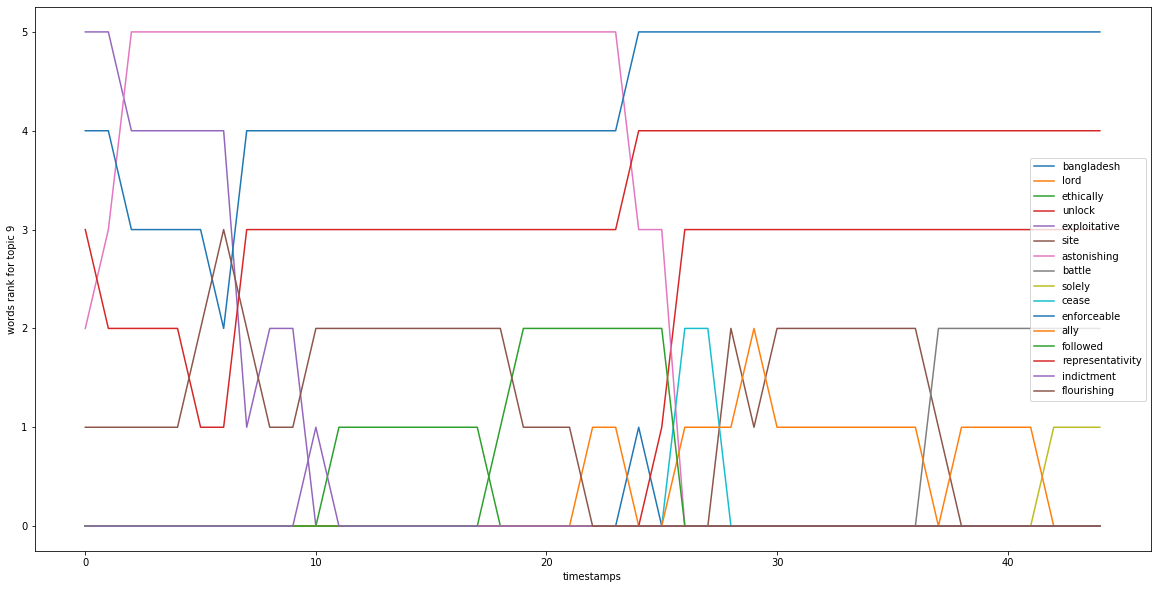

In [113]:
n_topic = 9
n_terms = 5
max_t = timestamp_train.max().values[0]

print_top_terms(n_topic, n_terms, max_t, cluster_terms)